In [ ]:
#requirements.txt

 # tensorflow>=2.3.0
 # keras==2.4.3  
 # nltk>=3.5
 # sacrebleu>=2.3.1
 # tabulate>=0.8.9
 # matplotlib>=3.1.0
 # scikit-learn>=0.24.0 
 # regex>=2020.11.13  


In [20]:
import string 
import re
import numpy as np
from numpy import array, argmax, random, take  
import pandas as pd 
from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.callbacks import ModelCheckpoint  
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.models import load_model  
from keras import optimizers  
import matplotlib.pyplot as plt  
from tabulate import tabulate  
from nltk.translate.bleu_score import corpus_bleu 
from sacrebleu.metrics import CHRF
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, RepeatVector, Dense, Bidirectional, Dropout


In [22]:
def read_text(filename):
    """
    Reads a text file and returns its contents as a string.
    """
    file = open(filename, mode='rt', encoding='utf-8')  
    text = file.read() 
    file.close()  
    return text 


def to_lines(text):
    """
    Splits a block of text into a list of sentences (lines)
    """
    sents = text.strip().split('\n')  
    return sents  


In [24]:
text_hin=read_text('eng-hin-dataset/IITB.en-hi.hi') # Hindi corpus
text_eng=read_text('eng-hin-dataset/IITB.en-hi.en') # English corpus

data_hin= to_lines(text_hin)
data_eng = to_lines(text_eng)

# Converting to DataFrame
df_hin = pd.DataFrame(data_hin)
df_eng = pd.DataFrame(data_eng)

In [25]:
df_eng.shape, df_hin.shape


((1659083, 1), (1659083, 1))

In [26]:
# Preprocessing english and Hindi data
df_eng[0] = df_eng[0].str.replace('[{}]'.format(string.punctuation), '', regex=True)
df_hin[0] = df_hin[0].str.replace('[{}]'.format(string.punctuation), '', regex=True)

df_eng[0] = df_eng[0].str.lower()
df_hin[0] = df_hin[0].str.lower()


df_eng.shape == df_hin.shape


True

In [27]:
# Here we remove rows from English and Hindi DataFrames that contain empty sentences

eng_zero = []
hin_zero = []

c = 0
for i in df_eng[0].str.strip().astype(bool):
    if not i:
        eng_zero.append(c)
    c += 1

c = 0
for i in df_hin[0].str.strip().astype(bool):
    if not i:
        hin_zero.append(c)
    c += 1

# Combine the indices of empty rows from both DataFrames and remove duplicates
remove_list = list(set(eng_zero + hin_zero))

# Drop empty sentence rows from both English and Hindi DataFrames
df_eng.drop(df_eng.index[remove_list], inplace=True)
df_eng.reset_index(inplace=True)

df_hin.drop(df_hin.index[remove_list], inplace=True)
df_hin.reset_index(inplace=True)


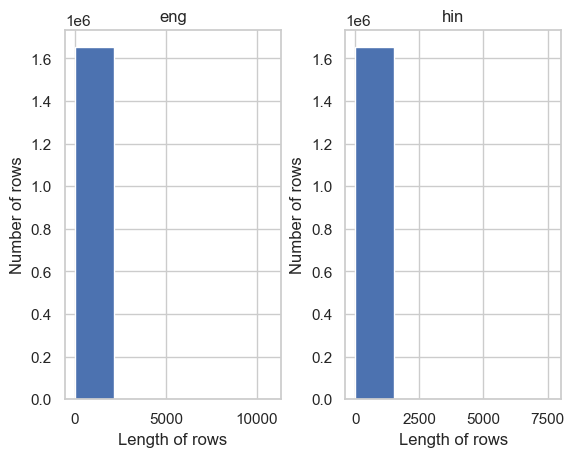

In [28]:
# Plotting histograms for sentence lengths 
fig = df_len.hist(bins=5)


for ax in fig.flatten():
    ax.set_xlabel("Length of rows")  
    ax.set_ylabel("Number of rows") 
    pass 


In [29]:
display(pd.concat([df_eng.head().reset_index(drop=True), 
                   df_hin.head().reset_index(drop=True)], 
                  axis=1, keys=['English', 'Hindi']))

English                                                 Hindi  \
    index                                               0 index   
0       0  give your application an accessibility workout     0   
1       1               accerciser accessibility explorer     1   
2       2  the default plugin layout for the bottom panel     2   
3       3     the default plugin layout for the top panel     3   
4       4  a list of plugins that are disabled by default     4   

                                                      
                                                   0  
0    अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें  
1                    एक्सेर्साइसर पहुंचनीयता अन्वेषक  
2               निचले पटल के लिए डिफोल्ट प्लगइन खाका  
3                ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका  
4  उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष...

In [30]:
# Removing rows where English sentences don't contain English letters or Hindi sentences contain English letters


eng_zero = []
hin_zero = []
c = 0

# Identify English rows without any lowercase English letters
for i in df_eng[0].str.contains('([a-z])'):
    if i == False:
        eng_zero.append(c)
    c += 1

c = 0

# Identify Hindi rows that incorrectly contain lowercase English letters
for i in df_hin[0].str.contains('([a-z])'):
    if i == True:
        hin_zero.append(c)
    c += 1


remove_list = list(set(eng_zero + hin_zero))

df_eng.drop(df_eng.index[remove_list], inplace=True)
df_eng.reset_index(inplace=True)

df_hin.drop(df_hin.index[remove_list], inplace=True)
df_hin.reset_index(inplace=True)

#percentage of removed rows
print("Percentage of data points removed =", (len(remove_list) / len(df_eng[0])) * 100)


Percentage of data points removed = 8.904017064335894


In [31]:
# tokenization function
def tokenization(lines):

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)

    return tokenizer


In [34]:
# We take first 50,000 sentences each for training from hindi and english dataset
eng_tokenizer = tokenization(df_eng[0][:50000])

eng_vocab_size = len(eng_tokenizer.word_index) + 1 #vocab size means number of unique words in the dataset

# Fixed length of the English sentences 
eng_length = 10

print('Size of English Vocabulary : %d' % eng_vocab_size)



Size of English Vocabulary : 3464


In [34]:
hin_tokenizer = tokenization(df_hin[0][:50000])

#Similarly we take tokenize and find vocab size for hindi dataset
hin_vocab_size = len(hin_tokenizer.word_index) + 1


hin_length = 10


print('Size of Hindi Vocabulary : %d' % hin_vocab_size)


Size of Hindi Vocabulary : 4149


In [38]:
def encode_sequences(tokenizer, length, lines):
    """
    Encoding text lines
    """
    seq = tokenizer.texts_to_sequences(lines)        
    seq = pad_sequences(seq,                          
                        maxlen=length,               
                        padding='post')               
    return seq


In [37]:
#preprocessed data
df = pd.DataFrame()


df['eng'] = df_eng[0][:50000]
df['hin'] = df_hin[0][:50000]

df.head()

,eng,hin
0,give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
1,accerciser accessibility explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक
2,the default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लगइन खाका
3,the default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका
4,a list of plugins that are disabled by default,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष...


In [40]:

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.25, random_state=42)

# Encode training sentences
trainX = encode_sequences(eng_tokenizer, eng_length, train.iloc[:, 0])
trainY = encode_sequences(hin_tokenizer, hin_length, train.iloc[:, 1])

# Encode test sentences
testX = encode_sequences(eng_tokenizer, eng_length, test.iloc[:, 0])
testY = encode_sequences(hin_tokenizer, hin_length, test.iloc[:, 1])


In [38]:
model = Sequential()


#ENCODER

# Embedding Layer (Encoder input)
model.add(Embedding(input_dim=eng_vocab_size, 
                    output_dim=512,           
                    input_length=eng_length,  
                    mask_zero=True))          

# Bidirectional LSTM Layer 

model.add(Bidirectional(LSTM(units=512,
                             return_sequences=False, #Outputs only final state
                             dropout=0.3,
                             recurrent_dropout=0.3)))


#DECODER

# RepeatVector Layer
model.add(RepeatVector(hin_length))

# LSTM 

model.add(LSTM(units=512,
               return_sequences=True, #Outputs a hidden state for each timestep
               dropout=0.3,
               recurrent_dropout=0.3))


#softmax to predict the most likely word at each timestep
model.add(Dense(hin_vocab_size, activation='softmax'))

model.summary()


In [39]:
rms = optimizers.RMSprop(learning_rate=0.001)  
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')  


In [41]:
final_model_filename='output/Final_BLSTM_Model.keras' #saving the model in this file

# Training the model with the checkpoint
checkpoint = ModelCheckpoint(final_model_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=114, 
                    batch_size=256,
                    validation_split=0.25,
                    callbacks=[checkpoint],
                    verbose=1)


model.save(final_model_filename)  # Saving the final model after training
print(f"Final model saved as {final_model_filename}")


from IPython.display import FileLink
FileLink(final_model_filename)

Epoch 1/114
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.5420
Epoch 1: val_loss improved from inf to 2.65599, saving model to /kaggle/working/Final_BLSTM_Model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 4.5208 - val_loss: 2.6560
Epoch 2/114
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.6251
Epoch 2: val_loss improved from 2.65599 to 2.53493, saving model to /kaggle/working/Final_BLSTM_Model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 2.6250 - val_loss: 2.5349
Epoch 3/114
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.5577
Epoch 3: val_loss improved from 2.53493 to 2.48650, saving model to /kaggle/working/Final_BLSTM_Model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 2.5575 - val_loss: 2.4865
Epoch 4/114
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.5023
Epoch 4: val_loss improved from 2.48650 to 2.45624, saving model to /kaggle/working/Final_BLSTM_Model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 2.5023 - val_loss

/kaggle/working/Final_BLSTM_Model.keras

In [43]:

model = load_model('output/Final_BLSTM_Model.keras')

# Using the model to predict translations for the test English input sequences
preds = model.predict(testX.reshape((testX.shape[0], testX.shape[1])))
preds = np.argmax(preds, axis=-1)


391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [44]:
def get_word(n, tokenizer):
  
    if isinstance(n, (list, np.ndarray)):
        n = int(n) 


    for word, index in tokenizer.word_index.items():
        if index == n:
            return word  # Returning the word 

 
    return None


In [45]:
# Converting predicted token sequences into readable Hindi sentences using the tokenizer

preds_text = []


for i in preds:
    temp = [] 

    #Iterating through each token in the sequence
    for j in range(len(i)):
   
        value = i[j][0] if isinstance(i[j], (np.ndarray, list)) else i[j]

    
        t = get_word(int(value), hin_tokenizer)

  
        if j > 0:
           
            prev_value = i[j - 1][0] if isinstance(i[j - 1], (np.ndarray, list)) else i[j - 1]
            prev_t = get_word(int(prev_value), hin_tokenizer)

       
            if (t == prev_t) or (t is None):
                temp.append('') 
            else:
                temp.append(t)  
        else:
       
            temp.append(t if t is not None else '')


    preds_text.append(' '.join(temp))


In [69]:


pred_df = pd.DataFrame({
    'Actual Words (Hindi)': test.iloc[:, 1],     
    'Predicted Words (Hindi)': preds_text,         
    'English Words': test.iloc[:, 0]              
})


sampled_df = pred_df[['English Words', 'Predicted Words (Hindi)']].sample(50)
print(tabulate(sampled_df, headers='keys', tablefmt='fancy_grid', showindex=False))


╒══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════╕
│ English Words                                                                                                        │ Predicted Words (Hindi)                  │
╞══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪══════════════════════════════════════════╡
│ send this information over an insecure connection                                                                    │ अगली में से  इस सूचना को भेजें                     │
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────┤
│ go to a random image of the gallery                                                                                  │ दीर्घा के बेतरतीब छवि पर जाएँ                    

In [47]:
# Extracting actual and predicted words from DataFrame
references = pred_df['Actual Words (Hindi)'].apply(lambda x: x.split()).tolist() 
hypotheses = pred_df['Predicted Words (Hindi)'].apply(lambda x: x.split()).tolist() 

In [48]:
# Computing BLEU Score 

bleu_score = corpus_bleu([[ref] for ref in references], hypotheses)
print(f"BLEU Score: {bleu_score:.4f}")

# Computing CHRF Score 

hypotheses_str = [" ".join(h) for h in hypotheses]
references_str = [" ".join(r) for r in references]


chrf = CHRF()
chrf_score = chrf.corpus_score(hypotheses_str, [references_str])
print(f"CHRF Score: {chrf_score.score:.4f}")


BLEU Score: 0.5626
CHRF Score: 75.6100


In [49]:
# Translating custom English sentences

def encode_input_custom(text, tokenizer, max_len):

    seq = tokenizer.texts_to_sequences([text.lower()])

   
    if len(seq[0]) == 0:
        print("Try different input.")
        return None


    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    return padded


def translate_custom_input(text):
    # Encoding the custom input using the tokenizer 
    encoded = encode_input_custom(text, eng_tokenizer, testX.shape[1])

    
    if encoded is None:
        return "Invalid or unknown input."


    pred = model.predict(encoded)
    pred = np.argmax(pred, axis=-1)

    #Translation output
    temp = []
    for j in range(len(pred[0])):
     
        value = pred[0][j]
        t = get_word(int(value), hin_tokenizer)

       
        if j > 0:
            prev_value = pred[0][j - 1]
            prev_t = get_word(int(prev_value), hin_tokenizer)

            if (t == prev_t) or (t is None):
                temp.append('')  
            else:
                temp.append(t) 
        else:
            temp.append(t if t is not None else '')  

    #Translated text
    return ' '.join(temp).strip()


In [68]:
# This block is for testing with prompts
custom_eng_input = "Number of files" # <- Enter your inputs here ,an exaple is given
translated = translate_custom_input(custom_eng_input)

print("English:", custom_eng_input)
print("Hindi:", translated)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
English: Number of files
Hindi: चिड़ी की संख्या
